## ARIMA  analysis. 
## Tests for stationarity. AC, PAC, ADF (Augmented Dickey-Fuller).

### Determining Autocorrelation and Partial Autocorrelation to better understand data.
Glance on ACF - Autocorrelation Function and PACF - Partial Autocorrelation Function

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

from src.data.get_data import CSVsLoader
from src.common.globals import G
from src.features.build_features import FeatureEngineering as FE
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

PROJECT_PATH = G.get_project_root()
DATA_DIR_PROCESSED = os.path.join(PROJECT_PATH, r'data\03_processed\daily_full')

In [3]:
df = CSVsLoader(ticker='MSFT', directory=DATA_DIR_PROCESSED)

2023-09-11 09:27:12 - src.data.get_data - INFO - Loaded "..\P7-Trading-Bot\data\03_processed\daily_full\MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"


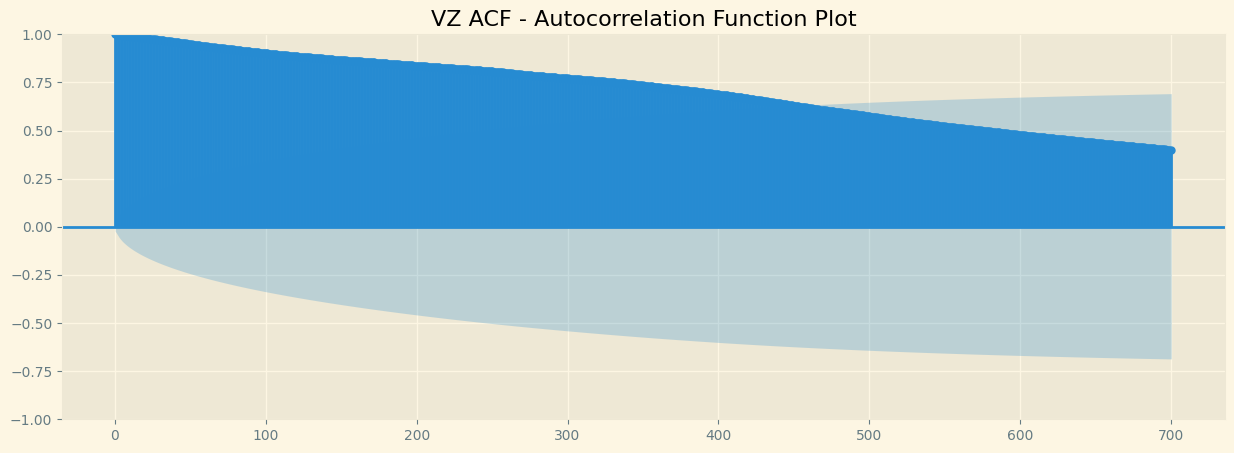

In [6]:
figure_AXF = plot_acf(df['Adj Close'], lags=700, title='VZ ACF - Autocorrelation Function Plot', alpha=0.05)

From above we can see that our values can be predicted from values lagging about 450 days if we count the all relationships including indirect ones. This Will give us an indication whether we can use MA (Moving Average) model and if so what is the lag we should use.

Now we will take a look how to prevent multicolinearity using Partial Autocorrelation Function (PACF) plot. This chart will show us how many lags actually impacting our time series after removing the noise. Or How many lags actually have a direct impact on our time series. PACF will give us an idea of how to build our AR model.

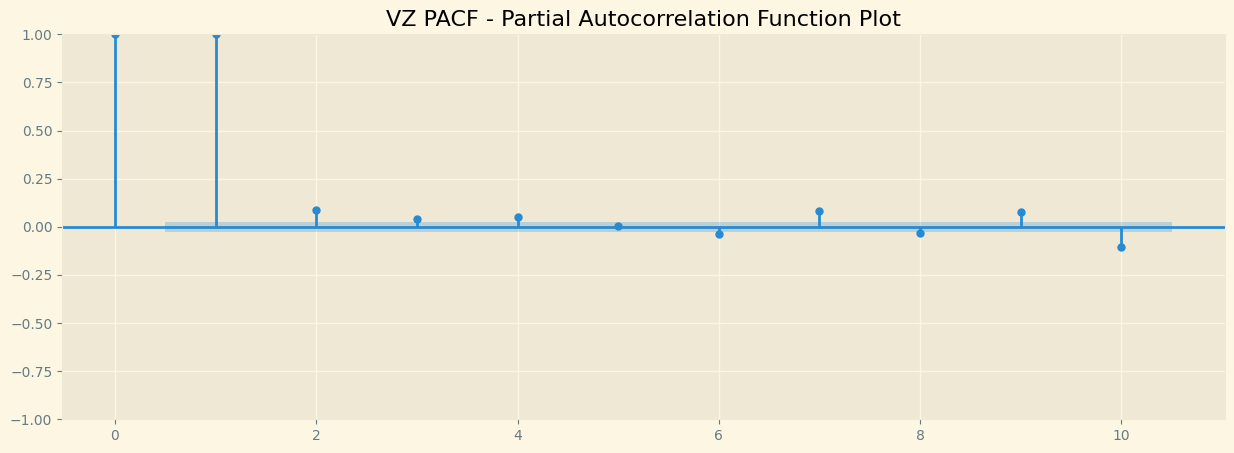

In [7]:
figure_AXF = plot_pacf(df['Adj Close'], lags=10, method='ols' , title='VZ PACF - Partial Autocorrelation Function Plot')

We can see few things here : 
* There are many Autocorrelation values from ACF plot that are very close to 1. This means that the time series is not random. And strongly suggest that we see non-stationary time series.
* We have very high degree of correlation between the lag 1 and data in PACF plot. This means that we can use AR model with lag 1. AR(1) model.
* We can see almost linear decay at ACF

let's take a look at correlation using pandas native functions as well. 

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

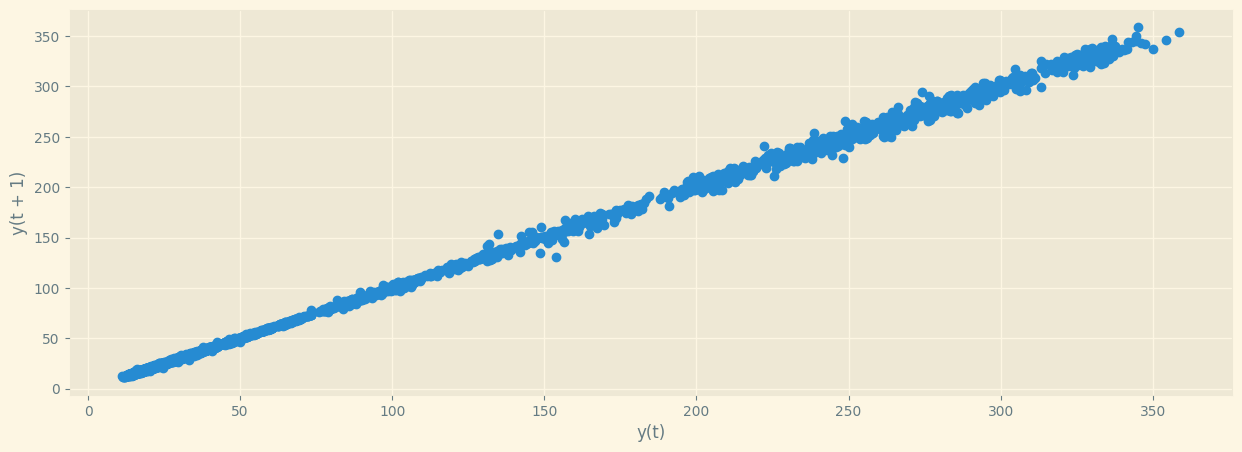

In [10]:
lag_plot(df['Adj Close'], lag=1)

### ADF Test
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance)  
This test’s null and alternate hypotheses are:  
* Null Hypothesis: The series has a unit root (value of a =1)
* Alternate Hypothesis: The series has no unit root.

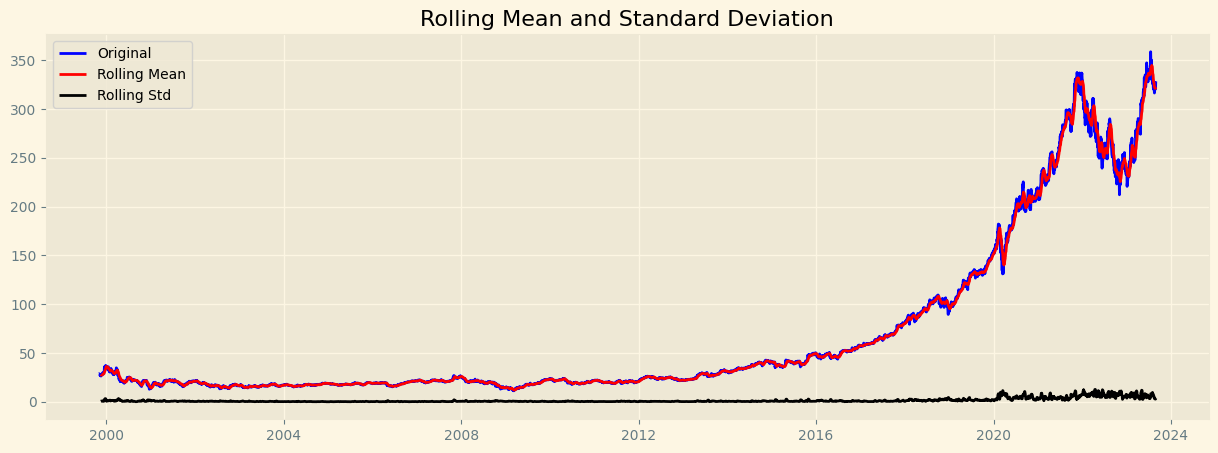

Results of dickey fuller test
Test Statistics                   2.726464
p-value                           0.999088
No. of lags used                 34.000000
Number of observations used    5960.000000
critical value (1%)              -3.431448
critical value (5%)              -2.862025
critical value (10%)             -2.567028
dtype: float64


In [13]:
#Test for staionarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Adj Close'])

Increasing mean and different STD can be seen on the plot. This is an indication that our time series is not stationary.  
We also see p-value grater than 0.05. This means that we can not reject the null hypothesis. And our time series is not stationary.

### Isolating time series from trend and seasonality.
Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

<Figure size 1500x500 with 0 Axes>

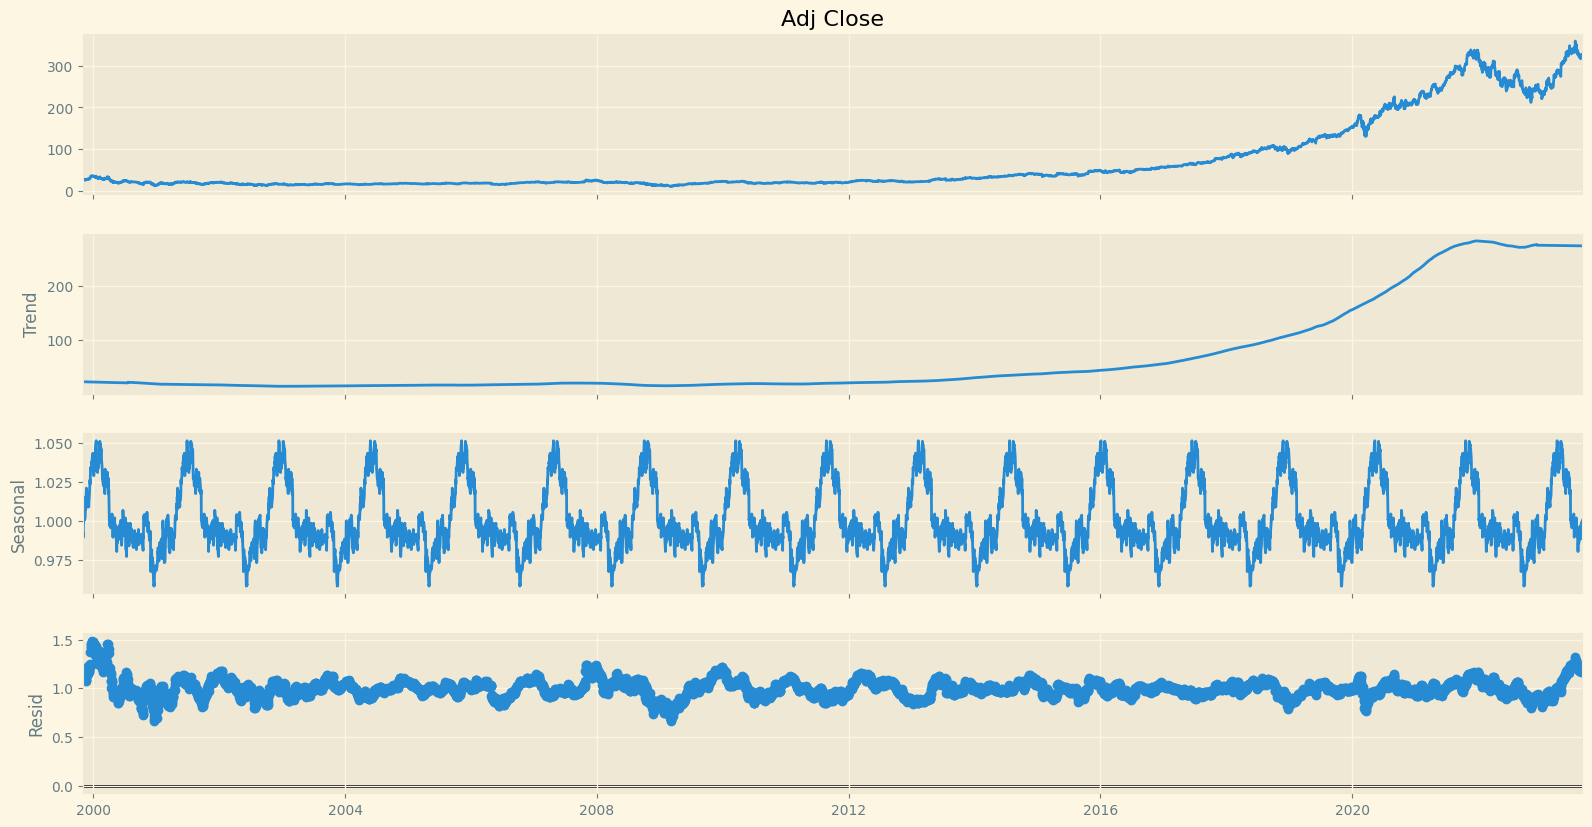

In [15]:
result = seasonal_decompose(df['Adj Close'], model='multiplicative', extrapolate_trend='freq', period=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Here are a few reasons why applying a logarithmic transformation is beneficial:

* <strong>Stabilizing Variance</strong>: By taking the logarithm of a time series, you can reduce the variability in the data. This is especially valuable when the variance of the series increases with the magnitude of the values. By compressing the scale, the logarithmic transformation can help make the variance more consistent across the range of values.

* <strong>Handling Exponential Growth</strong>: If your time series exhibits exponential growth, applying a logarithmic transformation can convert it into a more linear pattern. This can be useful when analyzing or modeling data that grows at a compounded rate over time. The transformation makes it easier to identify linear trends or relationships that might be masked in the original scale.

* <strong>Reducing Skewness</strong>: Skewness refers to the asymmetry of the data distribution. In some cases, a time series might have a skewed distribution, with a long tail on one side. By taking the logarithm, you can often reduce the skewness and make the distribution more symmetric. This can be particularly advantageous when using statistical techniques that assume normality or symmetric distributions.

* <strong>Making Trends More Linear</strong>: In some cases, trends in a time series might not be linear but exhibit exponential or power-law growth. Taking the logarithm can help transform these trends into more linear patterns. By doing so, you can often simplify the analysis, apply linear regression techniques, or capture the trend more effectively using simpler models.

In [18]:
df_log = FE.log_scale(df, column='Adj Close')

In [22]:
prediction_days = 28
train_data = df_log.iloc[-450-prediction_days:-prediction_days]['Adj Close']
test_data = df_log.iloc[-prediction_days:]['Adj Close']

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2797.494, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2799.493, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2799.493, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2795.789, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2799.253, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  450
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1396.895
Date:                Mon, 11 Sep 2023   AIC                           2795.789
Time:                        10:24:34   BIC                           2799.896
Sample:                             0   HQIC                          2797.408
                                - 450                                       

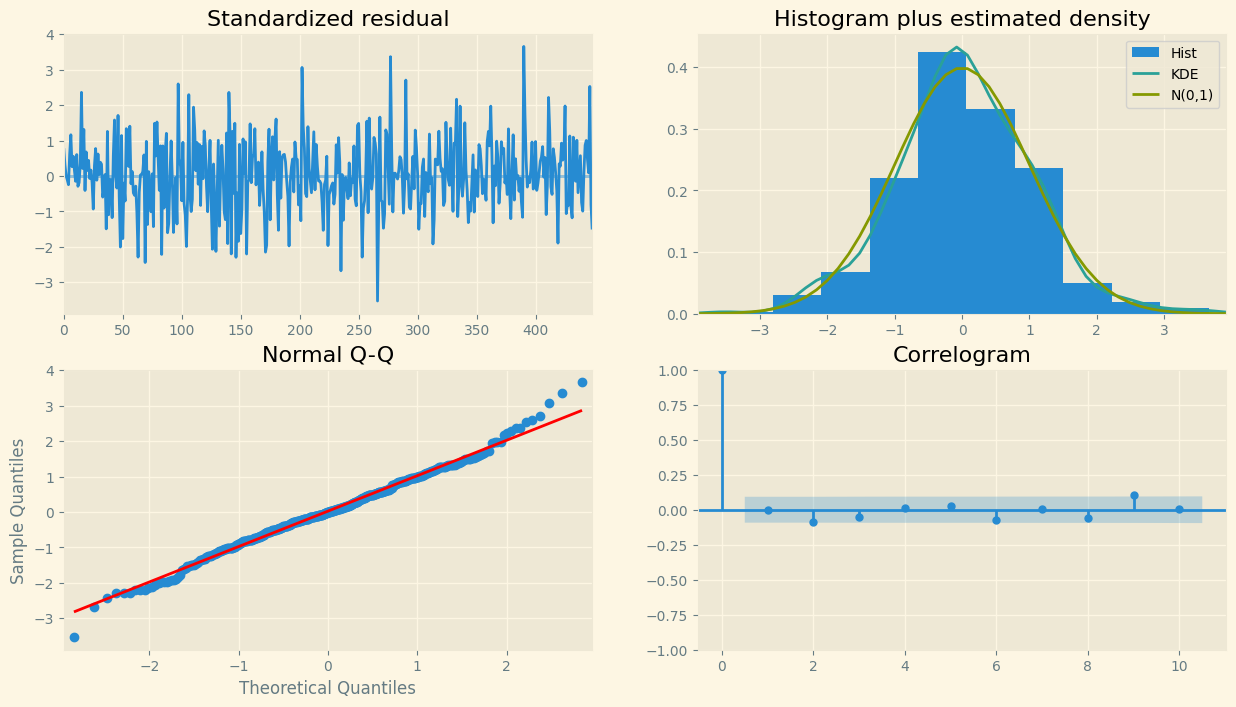

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                            test='adf',       # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1,              # frequency of series
                            d=None,           # let model determine 'd'
                            seasonal=False,   # No Seasonality
                            start_P=0, 
                            D=0, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


__Top left:__ The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

__Top Right:__ The density plot on the top right suggests a normal distribution with a mean of zero.

__Bottom left:__ The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

__Bottom Right:__ The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.